In [1]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator

from Logical import LogicalCircuit
from NoiseModel import construct_noise_model_QuantinuumH1_1

# clearing lib cache during development to force-update imports
import sys, importlib
importlib.reload(sys.modules['Logical'])
importlib.reload(sys.modules['NoiseModel'])

<module 'NoiseModel' from '/home/rasmitdevkota/projects/QCA/gatech-qec-project/src/NoiseModel.py'>

In [2]:
# We use the Steane code to demonstrate the library
stabilizer_tableau = [
  "XXXXIII",
  "IXXIXXI",
  "IIXXIXX",
  "ZZZZIII",
  "IZZIZZI",
  "IIZZIZZ",
]

noise_model = construct_noise_model_QuantinuumH1_1(n_qubits=10)

In [3]:
# Runs a shot on a noiseless simulator with an error at each of the physical qubits
shots = 1
simulator = AerSimulator()

outputs = []
for i in range(7):
    # Generates the circuit
    lqcirc = LogicalCircuit(2, [7,1,3], stabilizer_tableau, name="SteaneCodeCircuit")
    lqcirc.encode(0,1, max_iterations=1, initial_states=[0,1])

    # Inserts an error on both logical qubits
    lqcirc.add_error(0, i, 'X') # Can test X or Z errors
    lqcirc.add_error(1, i, 'X')

    # Adds QEC cycle and measurement
    lqcirc.perform_qec_cycle([0, 1])
    lqcirc.measure([0, 1], [0, 1])

    # Simulates the QEC cycle
    qc = transpile(lqcirc, backend=simulator)
    result = simulator.run(qc, shots=shots, memory=True).result()
    output = result.get_memory(lqcirc)
    outputs.append(output[0][:2])

# Outputs should all be 10 if the error correction worked properly
print(outputs)

['10', '10', '10', '10', '10', '10', '10']


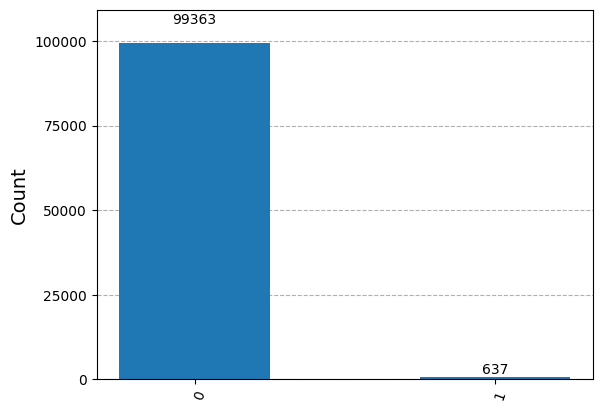

In [4]:
from qiskit.visualization import plot_histogram

#Tests encoding verification. Accuracy should be about 99.3%
simulator = AerSimulator()
lqcirc = LogicalCircuit(1, [7,1,3], stabilizer_tableau, "test_circuit")
lqcirc.encode(0, max_iterations=3)

qc = transpile(lqcirc, backend=simulator)
result = simulator.run(qc, shots=100000, memory=True, noise_model=noise_model).result()
output = result.get_memory(lqcirc)

zeros = 0
ones = 0

for o in output:
    if o[-1] == '0':
        zeros += 1
    if o[-1] == '1':
        ones += 1

counts = {'0': zeros, '1': ones}
plot_histogram(counts)

In [5]:
lqcirc = LogicalCircuit(1, [7,1,3], stabilizer_tableau, name='a')
lqcirc.encode(0)
lqcirc.perform_qec_cycle([0])
# lqcirc.draw('mpl')

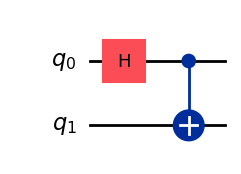

In [6]:
# We can also construct a logical circuit from a physical qubit circuit, first by constructing a QuantumCircuit:
pqc = QuantumCircuit(2)
pqc.h(0)
pqc.cx(0,1)
pqc.draw(output="mpl")

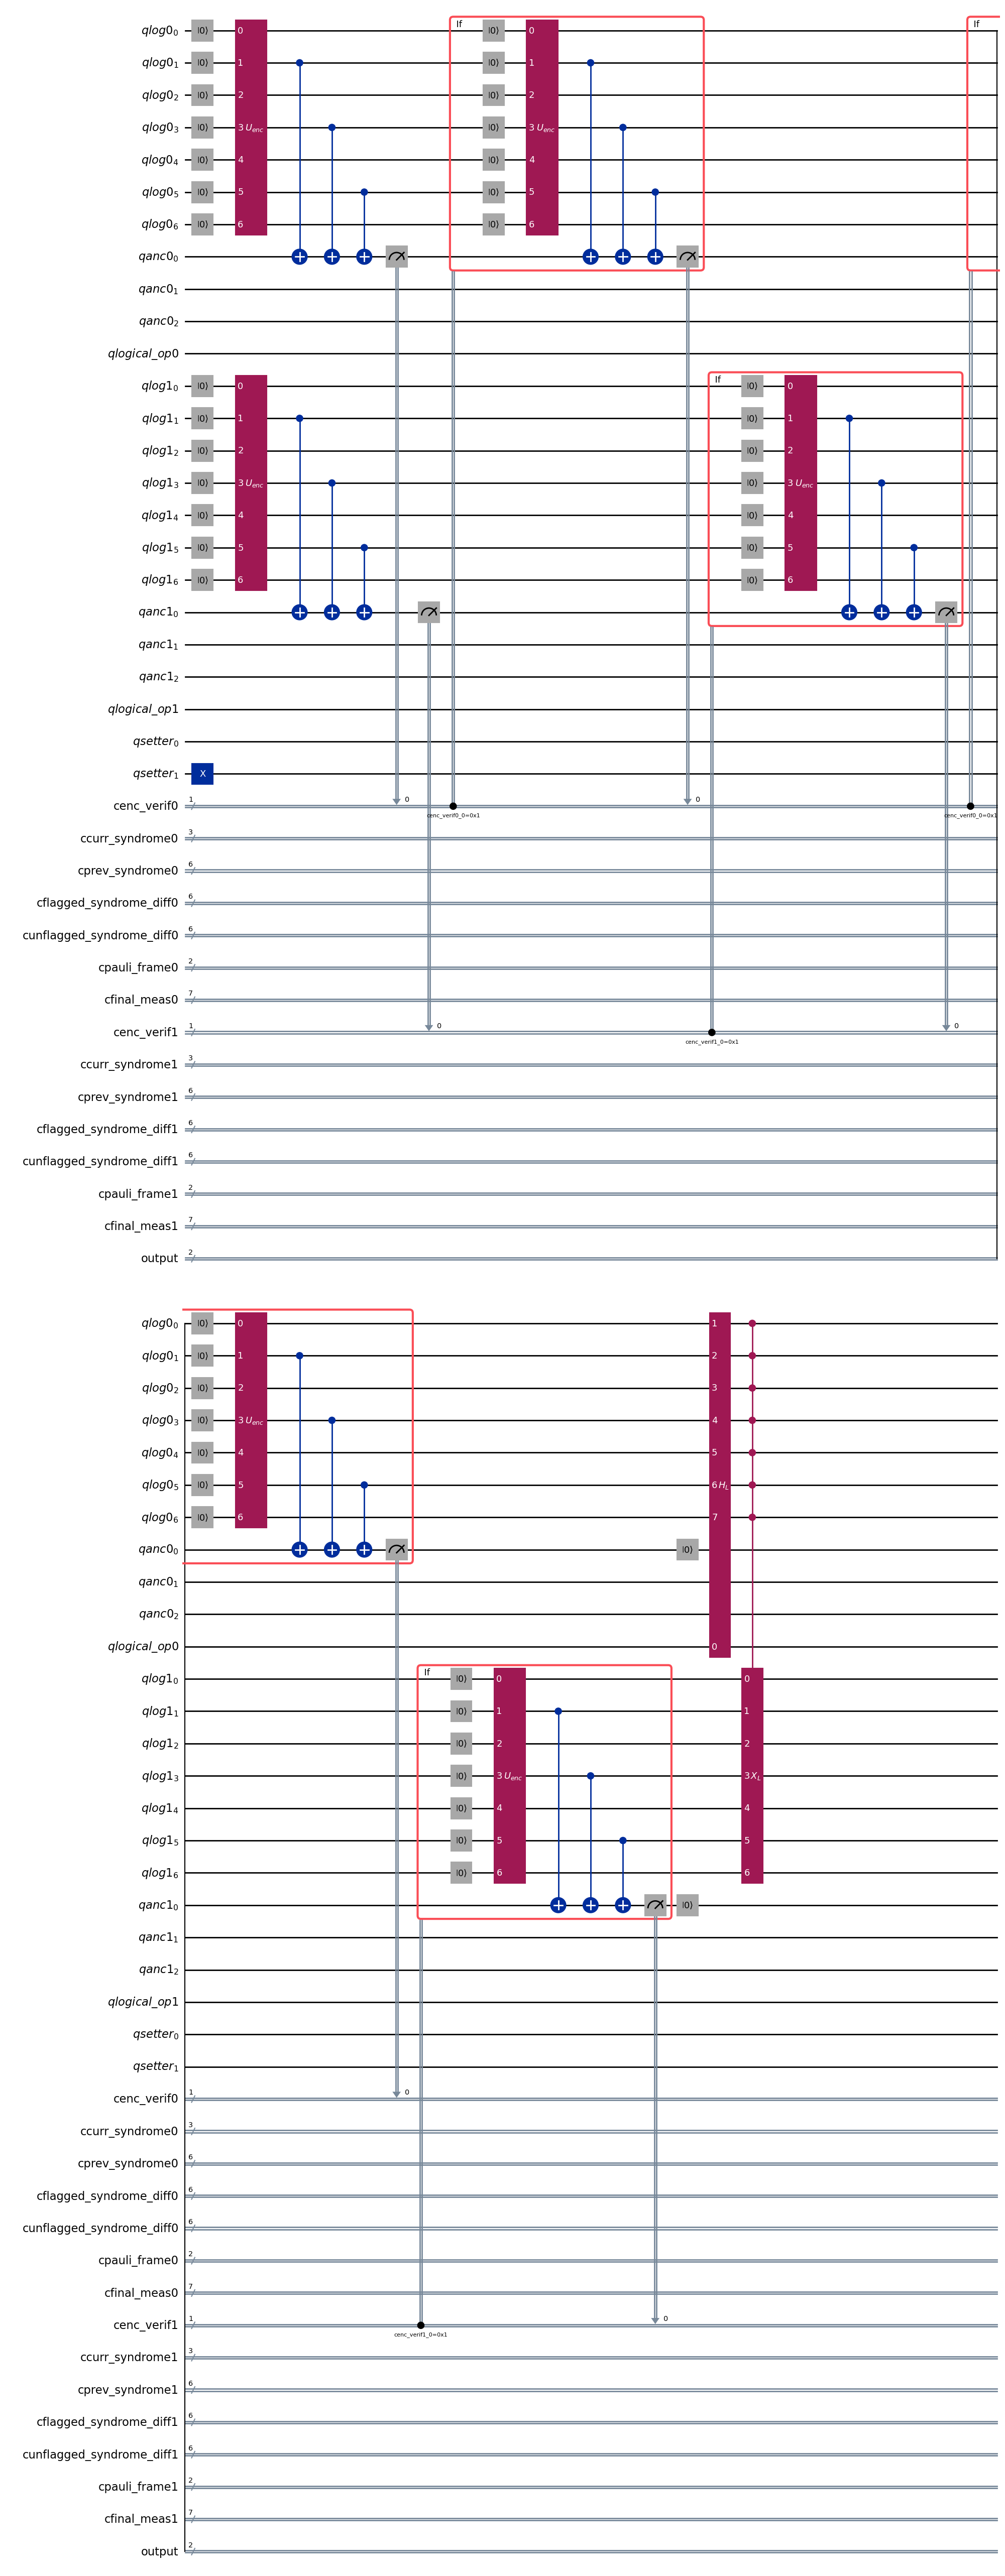

In [7]:
# Then, we convert the QuantumCircuit to a LogicalCircuit:
lqc = LogicalCircuit.from_physical_circuit(pqc, (7,1,3), stabilizer_tableau)
lqc.draw(output="mpl")